# Import Library

In [1]:
# !pip install awswrangler -q

In [3]:
import awswrangler as wr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load Data

In [4]:
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')

## 형변환
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

# Split Train/Test Data

In [5]:
## 학습/테스트 데이터 분류
train_df = monitor_hist[:int(len(monitor_hist) * 0.8)]
test_df = monitor_hist[int(len(monitor_hist) * 0.8):]
print(f"trian_df : {train_df.shape}, {train_df['event_date_min'].min(), train_df['event_date_min'].max()}")
print(f"test_df : {test_df.shape}, {test_df['event_date_min'].min(), test_df['event_date_min'].max()}")

trian_df : (722328, 59), (Timestamp('2021-01-01 00:00:00'), Timestamp('2022-06-02 13:23:00'))
test_df : (180582, 59), (Timestamp('2022-06-02 13:24:00'), Timestamp('2022-10-06 00:00:00'))


# Data PreProcessing

## PreProcessing Module

In [6]:
import pickle

def preprocessing_module(orig_df, single_col, continuous_col):
    df = orig_df.copy()
    
    print(f'Original Data Shape : {df.shape}')
    ## 형변환    
    df.loc[:,'event_date_min'] = pd.to_datetime(df['event_date_min'])    

    ## 컬럼명 변경
    df.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(df)]
        
    ## 단일값 컬럼 제거
    df.drop(single_col, axis = 1, inplace = True)
    print(f'Drop Single Value Columns : {df.shape}')
    
    ## 연속형 변수 보간법
    df.loc[:,continuous_col] = df[continuous_col].interpolate(method = 'polynomial', order=3)
    # df[continuouse_col] = df[continuouse_col].interpolate(method = 'linear')
    
    ## 파생변수 생성 (월, 계절, 시간)
    df.loc[:,'month'] = df['event_date_min'].dt.month
    df.loc[:,'season'] = np.where(df['month'].isin([12,1,2]), 1, ## 겨울
                            np.where(df['month'].isin([3,4,5]), 2, ## 봄
                                     np.where(df['month'].isin([6,7,8]), 3, 4))) ## 여름 / 가을 
    df.loc[:,'hour'] = df['event_date_min'].dt.hour
    print(f'Create Seasonal Value : {df.shape}')
    
    ## 더미변수 생성
    dummy_col = [col for col in list(df) if ('run_status' in col)]
    dummy_col.append('day_night')
    dummy_col.append('month')
    dummy_col.append('hour')
    dummy_col.append('season')
    df = pd.get_dummies(df, columns = dummy_col)
    print(f'Create Dummy Value : {df.shape}')
    return df

def save_pickle(object_name, object_):
    with open(f'{object_name}.pickle','wb') as fw:
        pickle.dump(object_, fw)
        
def read_pickle(object_name):
    with open(f'{object_name}.pickle','rb') as fr:
        object_ = pickle.load(fr)
    return object_

## Data PreProcessing

In [7]:
single_col = read_pickle('single_col')
box_plot_col = read_pickle('box_plot_col')

train_pps = preprocessing_module(train_df, single_col, box_plot_col)
test_pps = preprocessing_module(test_df, single_col, box_plot_col)

Original Data Shape : (722328, 59)
Drop Single Value Columns : (722328, 52)
Create Seasonal Value : (722328, 55)
Create Dummy Value : (722328, 113)
Original Data Shape : (180582, 59)
Drop Single Value Columns : (180582, 52)
Create Seasonal Value : (180582, 55)
Create Dummy Value : (180582, 102)


## Create Target Values

In [8]:
## Create Target Data
## col_n = 10, MSE = 400
target_base = ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1', 'sensor_plantation_temperature_1_1',
          'sensor_plantation_hum_1_1', 'sensor_inner_co2_1', 'sensor_inner_temperature1_2',
          'sensor_inner_hum1_2', 'sensor_plantation_temperature_1_2', 'sensor_plantation_hum_1_2', 'sensor_inner_co2_2',]

target = [col+'_target' for col in target_base]

In [9]:
train_pps[target] = train_pps[target_base].shift(30)
train_pps.reset_index(drop = True, inplace = True)
train_pps.dropna(axis = 0, inplace = True)

test_pps[target] = test_pps[target_base].shift(30)
test_pps.reset_index(drop = True, inplace = True)
test_pps.dropna(axis = 0, inplace = True)

## Split X/Y Data

In [10]:
train_x = train_pps[[col for col in list(train_pps) if col not in target]]
train_x = train_x.select_dtypes(include = ['int64', 'float64'])
train_y = train_pps[[col for col in list(train_pps) if col in target]]

test_x = test_pps[[col for col in list(test_pps) if col not in target]]
test_x = test_x.select_dtypes(include = ['int64', 'float64'])
test_y = test_pps[[col for col in list(test_pps) if col in target]]

## Data Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

scl_model_x = MinMaxScaler()
scl_model_x.fit(train_x)
train_x = scl_model_x.transform(train_x)
test_x = scl_model_x.transform(test_x)

scl_model_y = MinMaxScaler()
scl_model_y.fit(train_y)
train_y = scl_model_y.transform(train_y)
test_y = scl_model_y.transform(test_y)

save_pickle('scl_model_x', scl_model_x)
save_pickle('scl_model_y', scl_model_y)

# Model Test

## Build DNN Model

In [22]:
train_x.shape

(697080, 37)

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Conv1D, Input, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

tf.random.set_seed(1004)
K.clear_session()

model = Sequential([
    Input(shape = (train_x.shape[1:])),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(train_y.shape[1])
    # Dense(train_y.shape[1], activation = 'sigmoid')
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta = 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,914
Trainable params: 1,914
Non-trainable params: 0
_________________________________________________________________


## Model Fitting

In [18]:
hist = model.fit(train_x, train_y, epochs=100, batch_size = 32, verbose = 1, callbacks = early_stopping, validation_split=0.2)

ERROR! Session/line number was not unique in database. History logging moved to new session 72
Epoch 1/100
17427/17427 [==============================] - 36s 2ms/step - loss: 5.2089e-04 - mae: 0.0131 - mse: 5.2089e-04 - val_loss: 0.0010 - val_mae: 0.0233 - val_mse: 0.0010
Epoch 2/100
17427/17427 [==============================] - 36s 2ms/step - loss: 5.1884e-04 - mae: 0.0131 - mse: 5.1884e-04 - val_loss: 8.3646e-04 - val_mae: 0.0203 - val_mse: 8.3646e-04
Epoch 3/100
17427/17427 [==============================] - 36s 2ms/step - loss: 5.1709e-04 - mae: 0.0131 - mse: 5.1709e-04 - val_loss: 8.5531e-04 - val_mae: 0.0209 - val_mse: 8.5531e-04
Epoch 4/100
17427/17427 [==============================] - 36s 2ms/step - loss: 5.1591e-04 - mae: 0.0130 - mse: 5.1591e-04 - val_loss: 7.8325e-04 - val_mae: 0.0192 - val_mse: 7.8325e-04
Epoch 5/100
17427/17427 [==============================] - 36s 2ms/step - loss: 5.1489e-04 - mae: 0.0130 - mse: 5.1489e-04 - val_loss: 8.1189e-04 - val_mae: 0.0201 - val

# Model Results

## Check Model Loss

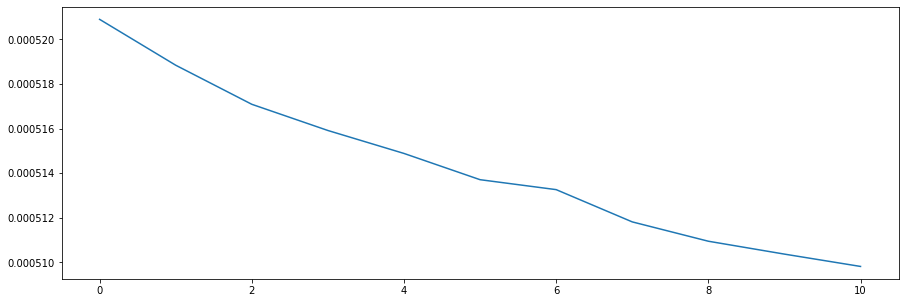

In [19]:
plt.figure(figsize = (15,5))
plt.plot(hist.history['loss'][:])
plt.show()

## Train Data Results

TRAIN SCORE
SCALED MSE : 0.0005848314745060915
SCALED RMSE : 0.024183289158137514
MSE : 2581.66356648662
RMSE : 50.81007347452491


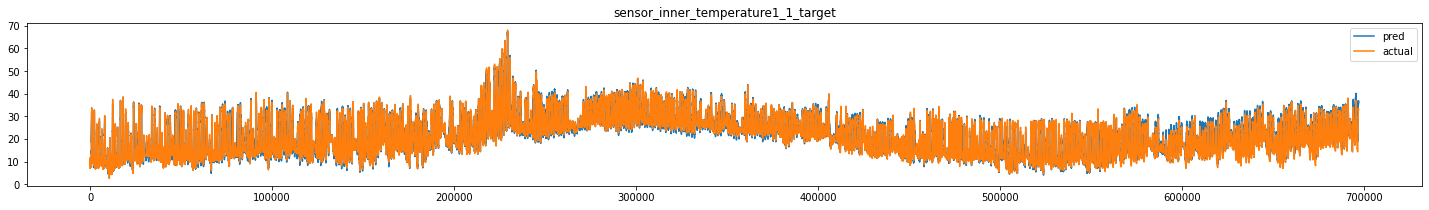

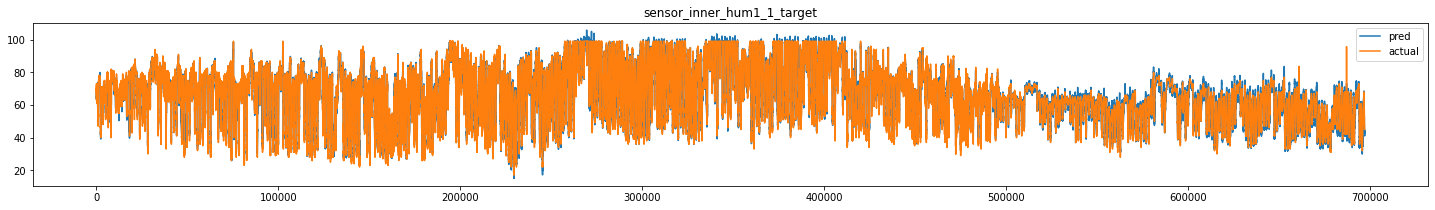

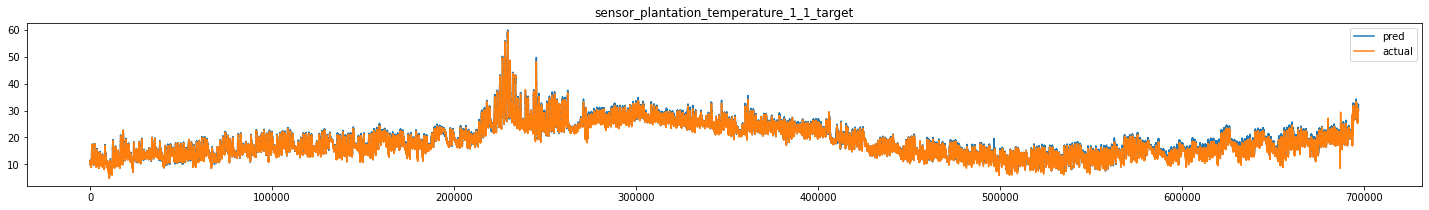

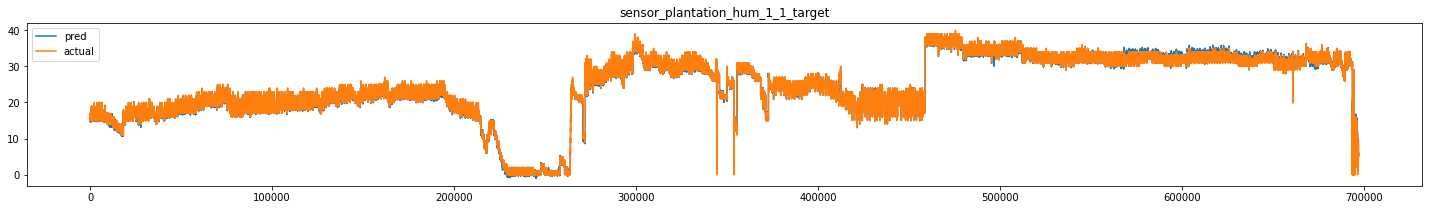

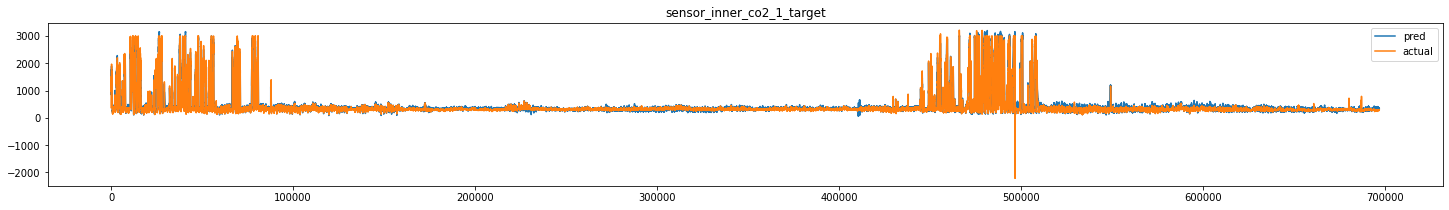

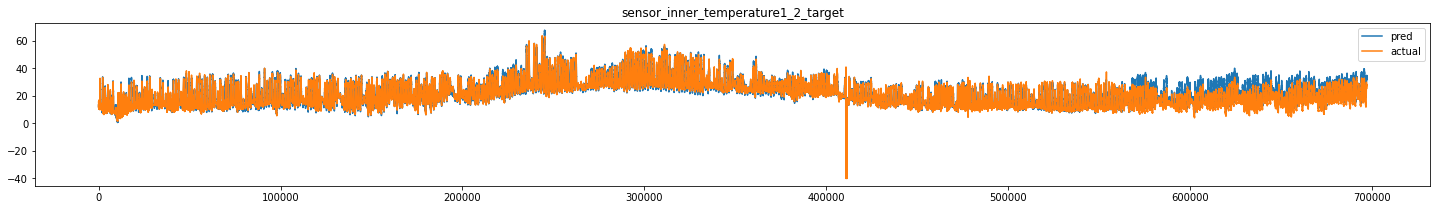

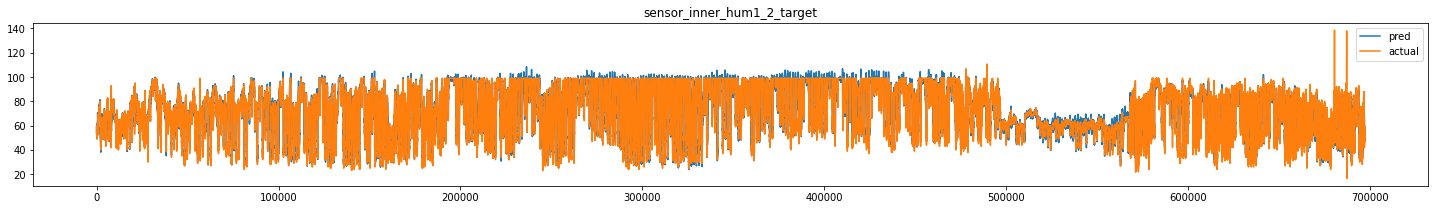

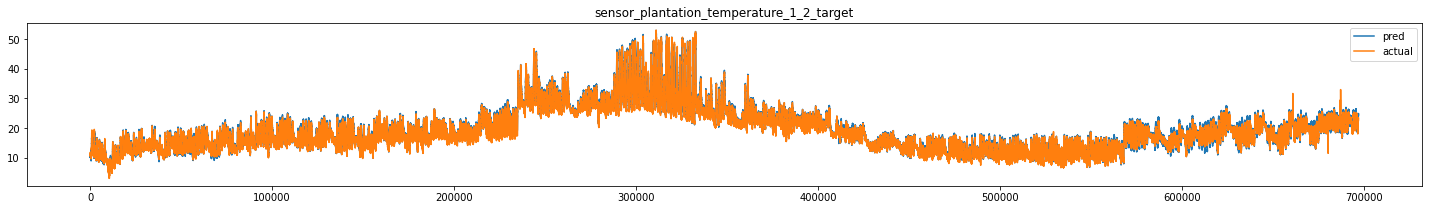

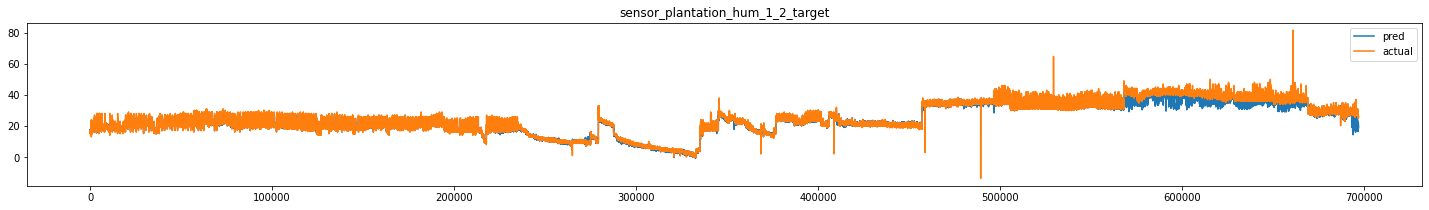

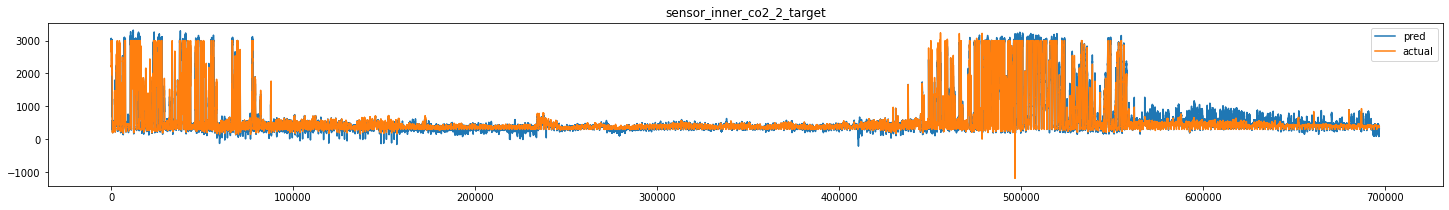

In [20]:
pred = model.predict(train_x)
actual = train_y

print('TRAIN SCORE') 
print(f'SCALED MSE : {mean_squared_error(actual, pred)}')
print(f'SCALED RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

pred = scl_model_y.inverse_transform(pred)
actual = scl_model_y.inverse_transform(actual)
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

for col in list(pred_df):
    plt.figure(figsize = (25,3))
    plt.plot(pred_df[col])
    plt.plot(actual_df[col])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()

## Test Data Results

TEST SCORE
SCALED MSE : 0.0015759415335304758
SCALED RMSE : 0.0396981301011833
MSE : 759.5358710926276
RMSE : 27.559678356117068


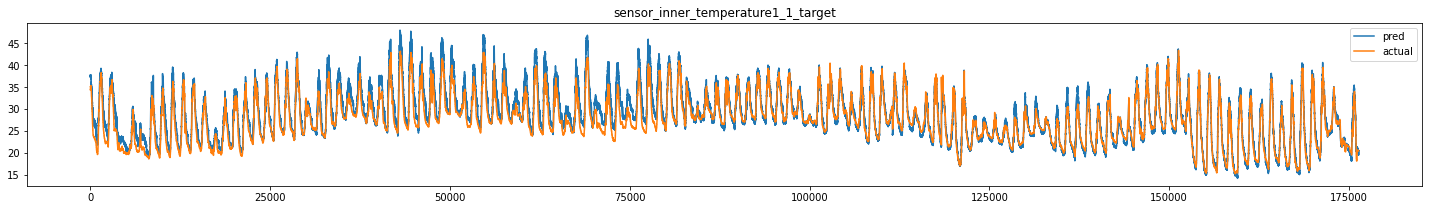

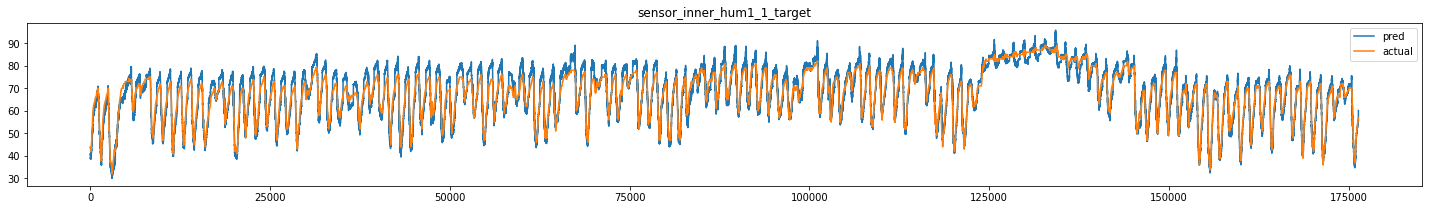

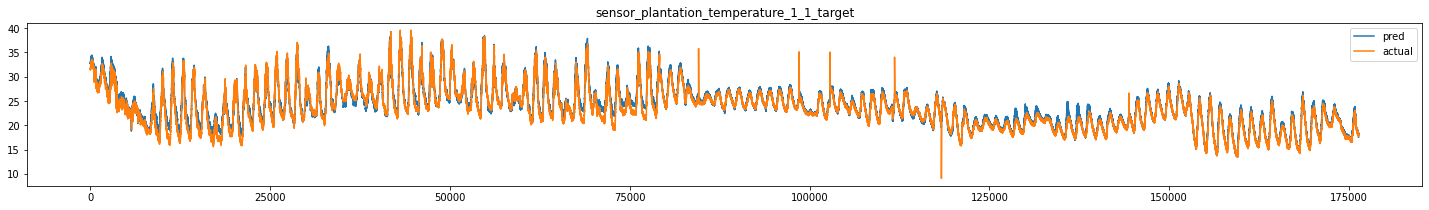

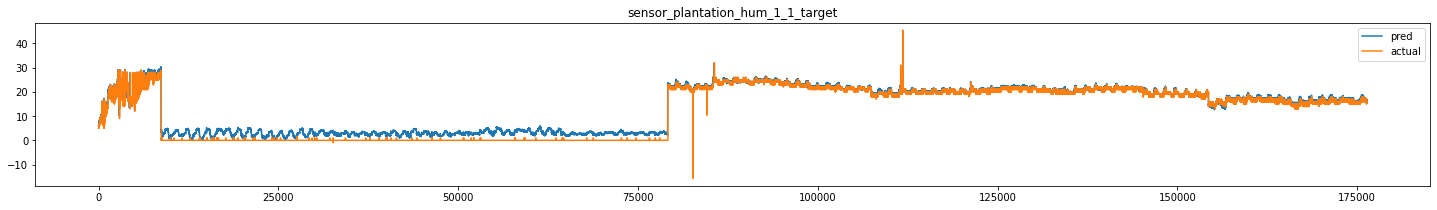

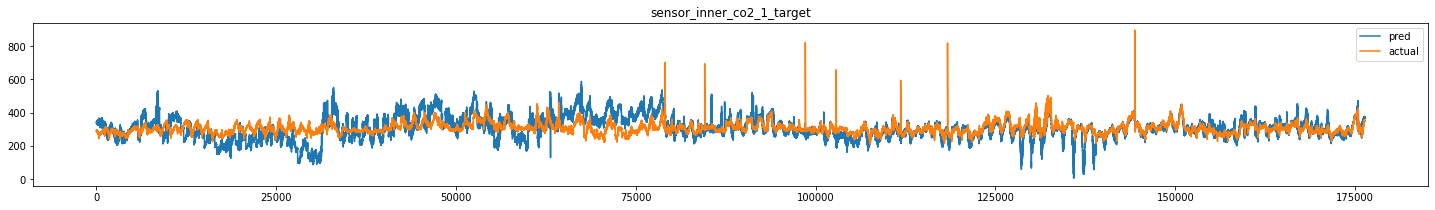

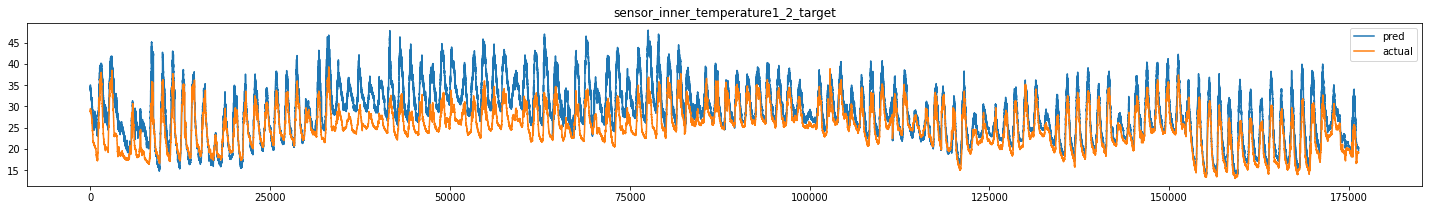

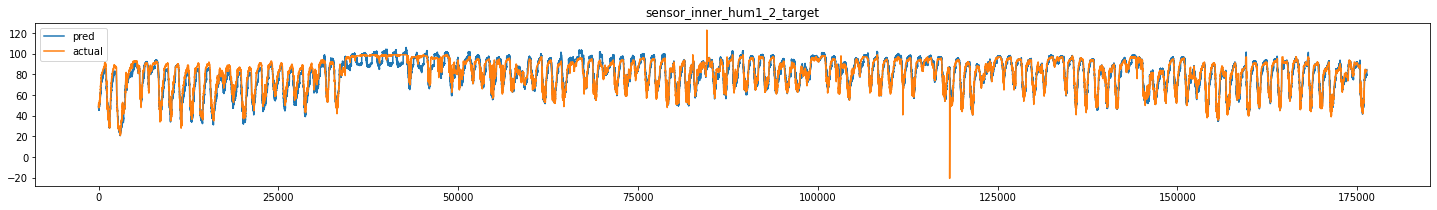

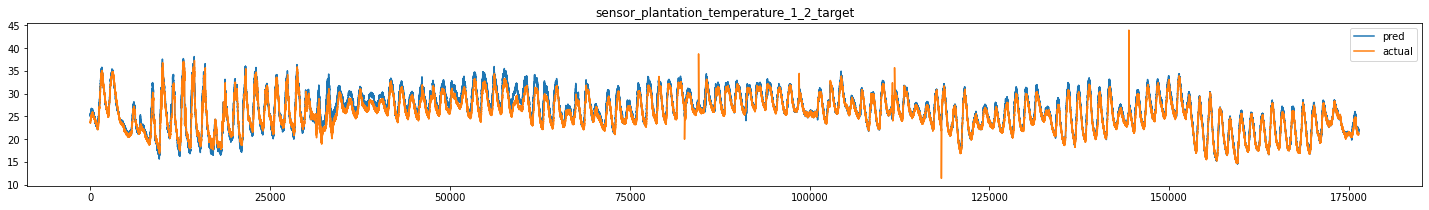

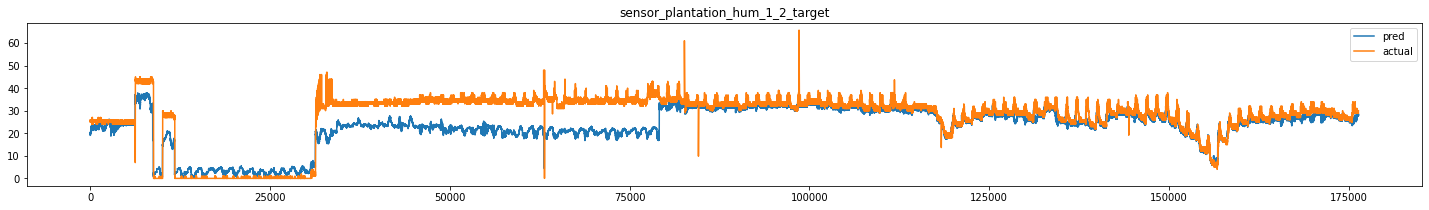

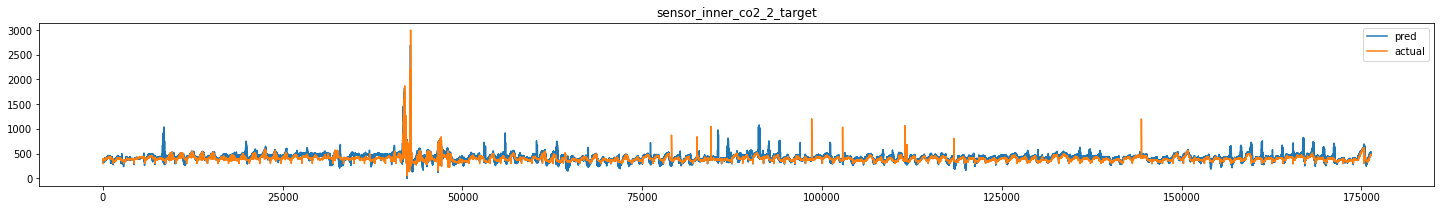

In [21]:
pred = model.predict(test_x)
actual = test_y

print('TEST SCORE') 
print(f'SCALED MSE : {mean_squared_error(actual, pred)}')
print(f'SCALED RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

pred = scl_model_y.inverse_transform(pred)
actual = scl_model_y.inverse_transform(actual)
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

for col in list(pred_df):
    plt.figure(figsize = (25,3))
    plt.plot(pred_df[col])
    plt.plot(actual_df[col])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()